# digital narratives of COVID-19: sentiment analysis

In this notebook we demonstrate how to perform sentiment analysis on the DHCOVID corpus using a modified version of [VADER](https://github.com/cjhutto/vaderSentiment#resources-and-dataset-descriptions) and `coveet` as a query + tidying tool. We visualize results using tables and bar charts with respect to each geographic area. 

Please feel free to modify this notebook or, if you would like to preserve this version, make a copy of it by clicking "File" > "Make a Copy..."

To follow along, we recommend running the script portions piecemeal, in order.

Author:
* Jerry Bonnell, j.bonnell@miami.edu, University of Miami


## 0. Setting Up

Before we get started, let's set up the notebook by installing and importing libraries we need. The `requirements.txt` file specifies all the packages to install on your computer for this notebook.

In [ ]:
!pip3 install -r requirements.txt  # may need to replace "pip3" with "conda"

In [3]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotnine import *
import vaderSentiment.vaderSentiment as vader
from sklearn.manifold import TSNE
from IPython.display import set_matplotlib_formats

import seaborn as sns
sns.set()
from pylab import rcParams
set_matplotlib_formats('svg')
rcParams['figure.figsize'] = 13, 16  # setting figure size
plt.rcParams.update({'font.size': 3})  # setting font size
pd.set_option('display.max_colwidth', None)


from senti_modeling import plot_pos_neg_senti_words

## 1. Querying + Tidying

We use the `coveet` tool to query and tidy tweets from all location-language pairs written between May 8, 2020 and May 14, 2020.

First, the `query` mode.

In [ ]:
!python coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14

If the Python you are using is coming from a conda environment (here called `blueberry`), use the following incantation instead:

In [ ]:
!conda activate blueberry; python coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14

Let us load in the query CSV and grab the text column so we can have a reference to the original text before any tidying was done. 

__NOTE__ be sure to adjust the filename accordingly!

In [43]:
original_text_col = pd.read_csv('dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv', index_col=0)['text']

Second, the `tidy` mode. 

__NOTE__ be sure to adjust the filename accordingly!

In [ ]:
!python coveet.py tidy -file dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv -lemmatize -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Once more, if the Python you are using is coming from a conda environment (here called `blueberry`), use the following incantation instead:

In [ ]:
!conda activate blueberry; python coveet.py tidy -file dhcovid_2021-5-8_2021-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv -lemmatize -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Let us load in the tidied CSV into a `pandas` DataFrame. 

__NOTE__ be sure to adjust the filename accordingly!

In [44]:
df = pd.read_csv('dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_stopworded_lemmatized.csv', index_col=0)

Let us attach the original text column to this data frame, so we can have it available for concordances, etc.

In [45]:
df['original_text'] = original_text_col

We will do four more preprocessing steps here in preparation for the sentiment analysis: 
  1. drop any rows whose text field is `NaN` (because that tweet was either full of stopwords and/or hashtags), 
  2. drop any rows whose text field is a duplicate because this could inflate irrelevant results, and
  3. filter out any emoji text from the tweets, e.g., `:emoji_not_identified_38:`

In [46]:
df = df.dropna(subset=["text"]).drop_duplicates(subset=['text'])

In [47]:
def filter_emoji_text(text):
    return re.sub(r":.+?:", "", text).strip()

In [48]:
df['text'] = df['text'].apply(filter_emoji_text)

Let us do a quick inspection to see what the data frame looks like.

In [49]:
df

,date,lang,geo,text,hashtags,original_text
0,2020-05-08,en,fl,heart test positive key senior liive facility thank responder frontline medical staff treat neighbor stay safe,NaN,my heart is with those who tested positive for covid19 at this keys senior living facility thank you to the first responders and frontline medical staff treating our neighbors please stay safe
1,2020-05-08,en,fl,probable cause death pneumonia acute respiratory distress syndrome complication person story little different heartbreaking way,NaN,the probable causes of death are the same over and over again pneumonia acute respiratory distress syndrome complications from covid19 each persons story though is a little different often in heartbreaking ways
2,2020-05-08,en,fl,chem trails blue angel cure government waste money instead actually useful,NaN,the chem trails of the blue angels cure covid19 that why the government is wasting all that money on them instead of something actually useful
3,2020-05-08,en,fl,lot higher report unemployment soar 147 job loss reach 205 million april coronavirus pandemic spread,NaN,its a lot higher then whats being reported unemployment soars to 147 job losses reach 205 million in april as coronavirus pandemic spreads
4,2020-05-08,en,fl,intel report deep state china use antitrump gate population control dog,NaN,intel reports deep state china use covid19 for antitrump and gates population control dog
...,...,...,...,...,...,...
224731,2020-05-14,es,es,persona contagiado,NaN,miles de personas contagiadas por el covid19
224732,2020-05-14,es,es,llevar mascarilla haber llevar proteccion 8m habiar conciencia cosa moral,NaN,1 no todos llevan mascarilla hay muchos que no llevan nada de proteccion 2 cuando el 8m no habia tanta conciencia del covid19 3 lo que estan haciendo va en contra de muchas cosas y no solo morales
224733,2020-05-14,es,es,luego flipar gente inculto haber valor seguir decir gripe casa notar haber cerca alguien hablar ignorancia mente cuadrado,NaN,luego me flipa la gente tan inculta que hay que tiene el valor de seguir diciendo que es una gripe por eso nos tienen en casa se nota quien no ha tenido cerca a alguien con covid19 y habla desde la ignorancia y su mente cuadrada
224734,2020-05-14,es,es,desafio musk tesla orden salud denuncia condado alameda amenaza abandonar california creer,NaN,el desafio de elon musk y tesla a las ordenes de salud de covid19 y su denuncia contra el condado de alameda y las amenazas de abandonar california crean


On to sentiment analysis!

## 2. Sentiment analysis

[VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that gives a polarity score from an input sentence in the form of 4 different measures: `pos` (positive), `neg` (negative), `neu` (neutral), and `compound` (a compound score). Following the authors of VADER, the `compound` score is used here but it can be interesting to compare the results with `pos` and `neg` scores. 

The `pos` and `neg` scores can be useful because we may be interested in establishing whether proportions of the tweets are balanced with similar amounts of positively and negatively framed text versus being "biased" toward one polarity or the other for each location-language pair.  

Moreover, because VADER works at the sentence-level the tool can be used as a means for providing sentiment to words that do not exist in the lexicon, e.g., the number `05062020` may be associated with tweet content that is highly positive in tone despite the number itself not having any polarity. This also means that "neutral" words that do exist in the lexicon, e.g., `trump`, can take on negative polarity because of the context the word appears in, e.g., `trump pandemic death crisis`. A desired effect for this study.



### 2.1 Creating a lexicon 

The primary challenge to introducing VADER as a sentiment analysis technique is the bilingual nature of this project: we must handle tweets that are written in both Spanish and English (with some tweets possibly making use of both in the same text). VADER is designed for English text, but it does offer a machine translation layer for non-English sentences. However, this is fragile at best because translation services are subject to term limits and we require a tool that can scale sentiment to large tweet datasets (over `>100K` tweets). 

The alternative is to replace the internal lexicon used by VADER with a custom lexicon file that contains both English and Spanish content. Developing one can be incredibly labor intensive, but recent work has been made to automatically generate very large emotion lexicons for non-English languages [(Buechel et al., 2020)](https://www.aclweb.org/anthology/2020.acl-main.112/). We combine their generated English and Spanish lexicons to produce a bilingual lexicon for VADER.        


In this first step, we concatenate the rows from the English (`en.tsv`) and Spanish lexicons (`es.tsv`). Let us download these data first from my repository to a directory called `memolon_tsv`. 

In [6]:
!git clone https://github.com/jerrybonnell/memolon_tsv

Cloning into 'memolon_tsv'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 71.96 MiB | 8.85 MiB/s, done.


In [7]:
memolon_en = pd.read_csv("memolon_tsv/en.tsv", delimiter='\t', encoding='utf-8')[
        ['word', 'valence', 'arousal', 'dominance']].dropna()
memolon_es = pd.read_csv("memolon_tsv/es.tsv", delimiter='\t', encoding='utf-8')[
    ['word', 'valence', 'arousal', 'dominance']].dropna()
lexicon_en_es = pd.concat([memolon_es, memolon_en])[['word', 'valence', 'arousal', 'dominance']]

Concatenating them isn't a straightforward solution because there are some duplicate entries among the two lexicons, for instance:

In [8]:
lexicon_en_es.loc[lexicon_en_es['word'] == 'vamos']

,word,valence,arousal,dominance
11568,vamos,5.64,4.08,5.68
317364,vamos,5.13,3.68,5.33


Because it isn't obvious which lexicon has the "right" polarity, we take the mean for these duplicate words. 

In [8]:
lexicon_en_es = lexicon_en_es.groupby('word').mean().reset_index()

In [9]:
lexicon_en_es.loc[lexicon_en_es['word'] == 'vamos']

,word,valence,arousal,dominance
3304140,vamos,5.385,3.88,5.505


Memolon uses a 1-to-9 scale with "5" encoding the neutral value. Let us scale this down to about the same range VADER uses in its lexicon, which is from $[-4, 4]$. 


In [10]:
lexicon_en_es[['valence', 'arousal', 'dominance']] = \
        lexicon_en_es[['valence', 'arousal', 'dominance']] - 5

In [11]:
lexicon_en_es.describe()

,valence,arousal,dominance
count,3.405735e+06,3.405735e+06,3.405735e+06
mean,7.432029e-03,-9.888526e-01,9.823874e-02
std,5.901449e-01,3.524430e-01,4.105505e-01
min,-4.450000e+00,-1.950000e+00,-2.850000e+00
25%,-3.400000e-01,-1.230000e+00,-1.500000e-01
50%,1.000000e-02,-1.070000e+00,1.100000e-01
75%,3.700000e-01,-8.300000e-01,3.500000e-01
max,1.638000e+01,5.345000e+00,1.389000e+01


The custom lexicon is now ready; let us write the file to disk so that we can use it with VADER.

In [73]:
lexicon_en_es.to_csv(f'vaderSentiment/memolon_vader.txt', sep='\t', index=False, header=False)

## 2.2 Modifying VADER 

With the custom lexicon file in place, we can now ask VADER to use our customized lexicon in place of its own. 

In [50]:
analyzer = vader.SentimentIntensityAnalyzer(lexicon_file="memolon_vader.txt")

The following three lists/dictionaries must also be customized to include Spanish negations, adverbs, etc. I have already done most of the work but you may wish to go further. Here are the variables (uncomment to see what is currently there): 

In [55]:
#print(vader.BOOSTER_DICT)
#print(vader.NEGATE)
#print(vader.SPECIAL_CASES)

Let's have some examples to get a sense of the results. 

In [51]:
analyzer.polarity_scores("vamos a la playa")

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5131}

In [52]:
analyzer.polarity_scores("trump desmonta la incursion frustrada del regimen yo no mandaria un grupito sino un ejercito")

{'neg': 0.636, 'neu': 0.049, 'pos': 0.315, 'compound': -0.5488}

In [53]:
analyzer.polarity_scores("breaking dr fauci proclaims 8 new covid19 vaccines will be ready in the fall")

{'neg': 0.223, 'neu': 0.103, 'pos': 0.673, 'compound': 0.5761}

From this point on, we have everything we need to perform sentiment analysis on the DHCOVID corpus.

## 3. Sentiment analysis tasks

## 3.1 Word polarity according to location-language pairs

We now apply VADER to each tweet in the tidied data frame. The polarity of each word is derived by accumulating the positive, negative, and composite polarity scores from tweets that contain said word. Collecting the composite score has an interesting effect as, depending on the polarity of the tweet a word appears in, it can be "nudged" either more positively or negatively. 

__Note__ that this approach is biased towards words that occur more frequently. This can be accounted for, but at the moment I consider this a desired effect.

In [54]:
score_dic = {'word':[], 'geo':[],'lang':[], 'neg_score':[],'pos_score':[], 'comp_score':[],
             'count':[], 'num_tweets':[]}
for (geo, lang), group in df.groupby(by=['geo','lang']):
    word_count = defaultdict(int)
    tweet_word_count = defaultdict(int)
    pos_word_scores = defaultdict(float)
    neg_word_scores = defaultdict(float)
    comp_scores = defaultdict(float)
    for row in tqdm(group.itertuples(), total=len(group)):
        if isinstance(row.text, str):
            vs = analyzer.polarity_scores(row.text)
            words = row.text.split()
            for w in words:
                word_count[w] += 1
                pos_word_scores[w] += vs['pos']
                neg_word_scores[w] += vs['neg']
                comp_scores[w] += vs['compound']
            for w in set(words):
                tweet_word_count[w] += 1
    for w in word_count.keys():
        score_dic['word'].append(w)
        score_dic['geo'].append(geo)
        score_dic['lang'].append(lang)
        score_dic['pos_score'].append(pos_word_scores[w])
        score_dic['neg_score'].append(neg_word_scores[w])
        score_dic['comp_score'].append(comp_scores[w])
        score_dic['count'].append(word_count[w])
        score_dic['num_tweets'].append(tweet_word_count[w])

100%|██████████| 11537/11537 [00:00<00:00, 19123.35it/s]


Organize the results into a new data frame. 

In [55]:
df_sentiment = pd.DataFrame(score_dic)
df_sentiment

,word,geo,lang,neg_score,pos_score,comp_score,count,num_tweets
0,conferencia,ar,es,17.149,35.794,15.8290,56,56
1,alberto,ar,es,32.591,51.650,3.6257,89,87
2,fernandez,ar,es,27.367,40.068,0.9725,71,68
3,presidente,ar,es,63.298,106.220,18.3741,177,173
4,sonriar,ar,es,1.090,1.706,0.2058,3,3
...,...,...,...,...,...,...,...,...
173720,matt,pe,es,0.762,0.148,-0.5886,1,1
173721,dam,pe,es,0.762,0.148,-0.5886,1,1
173722,zepita,pe,es,0.435,0.529,0.1680,1,1
173723,chancay,pe,es,0.435,0.529,0.1680,1,1


Let us normalize the positive and negative scores so that we can take its subtraction to get a "net" score.

In [56]:
df_sentiment['neg_score'] = (df_sentiment['neg_score'] - df_sentiment['neg_score'].mean()) / df_sentiment['neg_score'].std()
df_sentiment['pos_score'] = (df_sentiment['pos_score'] - df_sentiment['pos_score'].mean()) / df_sentiment['pos_score'].std() 
df_sentiment['comp_score'] = (df_sentiment['comp_score'] - df_sentiment['comp_score'].mean()) / df_sentiment['comp_score'].std() 

In [57]:
df_sentiment['net_score'] = df_sentiment['pos_score'] - df_sentiment['neg_score']

Following are the top 5 negative words overall.

In [58]:
df_sentiment.sort_values(by=['comp_score'], ascending=True).head(n=5)

,word,geo,lang,neg_score,pos_score,comp_score,count,num_tweets,net_score
115397,caso,mx,es,141.896785,123.098566,-134.889256,11366,9906,-18.798219
115387,contagio,mx,es,70.723318,48.339954,-120.884785,5011,4910,-22.383365
115510,pandemia,mx,es,69.747276,53.943149,-102.389690,5226,5179,-15.804128
115584,muerte,mx,es,49.135024,30.405913,-96.953400,3344,3222,-18.729111
115421,haber,mx,es,132.667152,109.659197,-75.390681,10272,9034,-23.007954


Top 5 positive words overall.

In [59]:
df_sentiment.sort_values(by=['comp_score'], ascending=True).tail(n=5)

,word,geo,lang,neg_score,pos_score,comp_score,count,num_tweets,net_score
63242,hoy,es,es,14.710002,23.780183,28.542509,1717,1659,9.070182
115372,hoy,mx,es,28.581722,41.531722,28.821107,3086,2964,12.950000
115507,personal,mx,es,18.694847,26.972090,28.942024,1988,1914,8.277243
115445,salud,mx,es,51.596254,66.879990,37.046534,5128,4901,15.283735
63078,nuevo,es,es,25.314245,39.814424,38.066398,2872,2652,14.500179


Let us visualize the top 10 most positive and negative words with respect to each location-language pair.

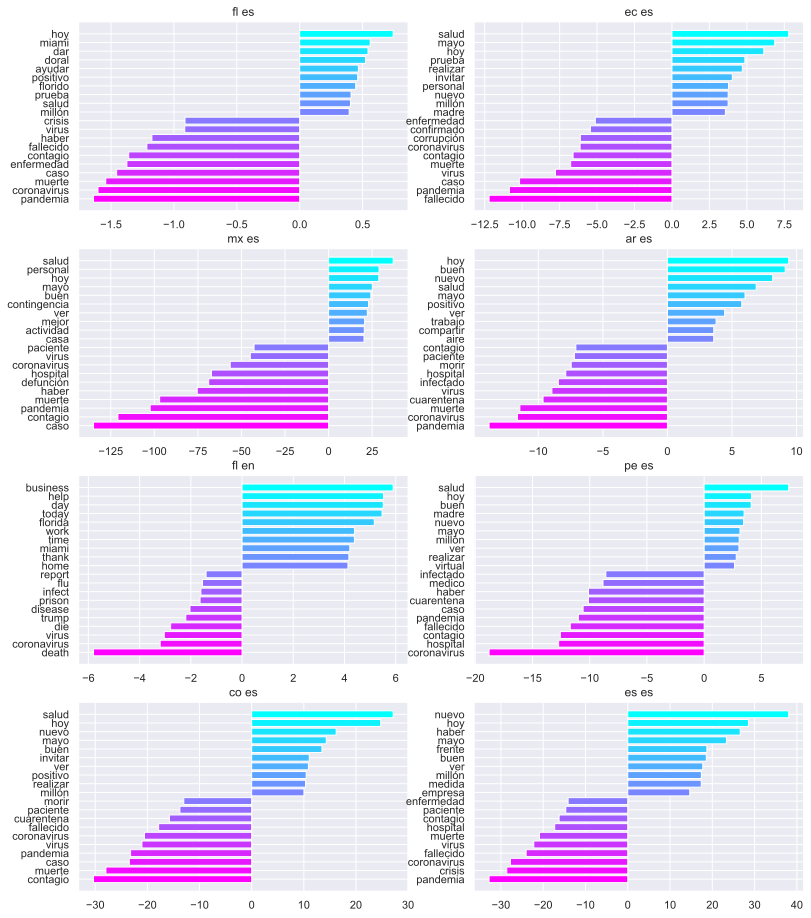

In [60]:
plot_pos_neg_senti_words(df_sentiment, x='word', y='comp_score', n=10, num_cols=2)

The visualization may prompt us to explore specific words for its context to better understand why they were categorized positively or negatively. The following gives the concordance of a word; adjust `search_word` and `location_lang_pair` accordingly.  

In [61]:
location_lang_pair = ('fl', 'es')
search_word = "prueba"

In [62]:
filt = lambda text: search_word in text
sub_df = df[(df['geo'] == location_lang_pair[0]) & (df['lang'] == location_lang_pair[1])]
sub_df[sub_df.apply(lambda x: filt(x["text"]), axis=1)]

,date,lang,geo,text,hashtags,original_text
163595,2020-05-08,es,fl,dejar enlace entrevista com abordar cambio prueba estandarizado act,NaN,aqui les dejo el enlace de la entrevista com de en la que abordamos los cambios con las pruebas estandarizadas act en tiempos de covid19
163607,2020-05-08,es,fl,abrir sitio prueba walmart,NaN,se abre el primer sitio de prueba covid19 en en walmart
163621,2020-05-08,es,fl,mensaje alcalde doral anunciar sitio prueba doral walmart supercenter 8651 nw 13th terrace doral fl 33126 asociacion,NaN,un mensaje del alcalde de doral anunciando el primer sitio de prueba covid19 de doral en el walmart supercenter 8651 nw 13th terrace doral fl 33126 en asociacion con
163626,2020-05-08,es,fl,firmo contrato millón libras empresa biotecnologia prenetic comprar kit prueba equipo división plan retorno,NaN,la firmo un contrato de mas de 4 millones de libras con la empresa de biotecnologia prenetics para comprar kits de pruebas de covid19 para todos los equipos de primera division dentro del plan retorno
163644,2020-05-08,es,fl,desastrar totalmente florido falla politica prueba asilos anciano,NaN,desastre total la florida falla en su politica de pruebas de covid19 en asilos de ancianos
163651,2020-05-08,es,fl,abrir hoy nuevo centro prueba centro convención miami beach,NaN,abre hoy nuevo centro de pruebas de covid19 en el centro de convenciones de miami beach
163684,2020-05-08,es,fl,informar lugar sur florida realizar prueba detectar descartar suscribeter canal youtube miamimundo,#miamimundo #miami #florida #informacion #noticias #miamimundo,te informa en que lugares del sur de florida puedes realizarte las pruebas para detectar o descartar el covid19 suscribete tambien en nuestro canal de youtube como miamimundo
163730,2020-05-08,es,fl,jugador fiorentina dar positivo prueba aun revelar identidad infectado,NaN,jugadores de la fiorentina dieron positivo en la prueba de covid19 aun no se revela la identidad de los infectados
163769,2020-05-09,es,fl,plasmatreat steinhagen alemania explorar alternativa desinfección plasma prueba promisorio leer noticia,#covid19enlaindustria,plasmatreat de steinhagen en alemania esta explorando la alternativa de desinfeccion con plasma las primeras pruebas son promisorias lea la noticia
163780,2020-05-09,es,fl,iglesia ubicado barrio nuevo york afectado empezar analisis coronavirus partir proximo mayo parte campaña aumentar prueba comunidad afroamericano latinoamericano,#9may,22 iglesias ubicadas en los barrios de nueva york mas afectados por el covid19 empezaran a hacer analisis del coronavirus a partir del proximo 12 de mayo como parte de una campaña para aumentar las pruebas en las comunidades afroamericana y latinoamericana


## 3.2 Tweet polarity according to location-language pairs

We may be interested in looking at the top positive and negative *tweets*. Since VADER already works at the sentence-level, this task is more straightforward. We will create a new column `tweet_compound_score` which contains the compound score given by VADER for that tweet. 

In [63]:
def apply_vader(text):
    return analyzer.polarity_scores(text)['compound']

In [64]:
vader_df = df.copy()
vader_df['tweet_compound_score'] = vader_df['text'].apply(apply_vader)

We will now do some pandas work to retrieve the top positive and negative tweets. Set the following variable `top_n` to be the desired number of top tweets to return, e.g., `1` will return the most positive and most negative tweet for each location-language pair.  

In [65]:
top_n = 1

In [66]:
grouped_score = vader_df.groupby(by=['lang', 'geo'])['tweet_compound_score']
sorted_top_indexes = grouped_score.nlargest(top_n).reset_index(level=[0,1]).index
sorted_bottom_indexes = grouped_score.nsmallest(top_n).reset_index(level=[0,1]).index
indexes_to_use = sorted_top_indexes.union(sorted_bottom_indexes)
vader_df.loc[indexes_to_use]

,date,lang,geo,text,hashtags,original_text,tweet_compound_score
134,2020-05-08,en,fl,inspiration adventure discovery beauty today celebrate national public garden day time appreciate tropical paradise fairchild member reopen reserve time ticket today,NaN,inspiration adventure discovery beauty and so much more today we celebrate national public gardens day and take time to appreciate our tropical paradise fairchild members we are reopen for you reserve your timed tickets today,0.9770
2770,2020-05-12,en,fl,notice democrat governors smallpox plague young old die street pile corps burn mass funeral pyre virus infection mortality rate identical damned flu,NaN,notice to democrat governors covid19 is not smallpox it is not the plague young and old are not dying in the streets there are no piles of corpses burning in mass funeral pyres we have a virus with infection and mortality rates identical to the damned flu get over it,-0.9793
8140,2020-05-09,es,ar,salud pan paz mundo invitar rezar junto 50000 alma unido oración mayo trave fb live canal youtube instagram difundir paz,#lafemuevemontañas,por el fin del covid19 por la salud el pan y la paz del mundo nos invita a rezar juntos 50000 almas unidas en oracion el 13 de mayo a traves de fb live en su canal de youtube e instagram difundir paz y,0.9700
15396,2020-05-13,es,ar,alguien patologia provocado daño irreparable medico negado mal visto victimar malo praxi jodar estigmatización contagiar alguien mejor altamente contagioso mejor aislar mejorar mientar sintoma,NaN,si alguien tiene 1 patologia provocada x un daño irreparable x medicos es negado y mal visto x ser victima de mala praxis no jodan de q estigmatizacion si se contagia alguien covid19 q mejor q saber es altamente contagioso mejor aislarse y mejorar no mientan sintomas,-0.9751
65571,2020-05-11,es,mx,hoy dar mejor amigo trabajo adio llego vida hombre noble buen corazon mejor siempre ayudar juzgar siempre trabajar gracia yair estara siempre,NaN,hoy tuve que darle a mi mejor amigo del trabajo el ultimo adios el covid19 llego a su vida y estuvo por mas de 3 dias era un hombre muy noble y de buen corazon de entre todos el mejor siempre ayudando no juzgaba y siempre trabajaba gracias por todo yair estaras siempre :red_heart:,0.9646
65703,2020-05-11,es,mx,creer creer influenza tuberculosis salmonella tifoidea herpes sida obesidad diabetes ansiedad anorexia existir bacteria virus enfermedad diario,NaN,creo en el covid19 pero tambien creo en la influenza en la tuberculosis en la salmonella en la tifoidea en el herpes en el sida en la obesidad en la diabetes en la ansiedad en la anorexia en que existen miles de bacterias virus y enfermedades diario,-0.9880
118015,2020-05-11,es,ec,jefe forense hamburgo ninguno persona enfermedad previo haber morir virustodo examinado haber cancer enfermedad pulmonar cronico grande fumador obese sufriar diabetes teniar enfermedad cardiovascular,NaN,jefe forense de hamburgo ninguna persona sin enfermedad previa ha muerto por el virustodos los examinados han tenido cancer una enfermedad pulmonar cronica eran grandes fumadores u obesos sufrian de diabetes o tenian una enfermedad cardiovascular,-0.9775
122230,2020-05-13,es,ec,oh señora fatima dulcisimo virger mario depositar mensaje paz amor esperanzatu carga espaldo devoto escucho petición paciencia esmero hoy fuerte ilumina gobierno,NaN,oh nuestra señora de fatima dulcisima virgen maria q depositaste en todos nosotros mensajes de paz amor y esperanzatu q cargas sobre tu espalda miles de devotos y q escuchas nuestras peticiones con paciencia y esmero hoy haznos fuertes ante el ilumina al gobierno,0.9616
125671,2020-05-08,es,co,edificio luz marina carrera 1r edificio luz marina carrera 1r edificio luz marina carrera 1r edificio luz marina carrera 1r edificio luz marina carrera 1r edificio luz marina carrera 1r,#84a #84a #84a #84a #84a #84a,edificio luz marina carrera 1ra 71 edificio luz marina carrera 1ra 71 edificio luz marina carrera 1ra 71 edificio luz marin

## 3.3 Overall location-langauge pair polarity 

Now that we have the polarity scores for each tweet, we can answer one more question: what is the overall polarity for each location-language pair? For instance, when taken together, are the tweets in `('fl', 'es')` mostly *positive* or *negative* and how does that compare with other regions? 

To answer this, we group the data frame `vader_df` by location-language pair and take the mean of compound scores in `tweet_compound_score` to overcome any bias in locations that produce overwhelmingly more tweets than other areas.  

In [67]:
summarized = vader_df.groupby(by=['lang', 'geo']).mean().reset_index()

The mean is a good parameter to estimate to get an overall sense of how positive or negative something is. Because statistics can vary, we should go further and derive a 95% confidence interval in order to supply confidence to claims like "the tweets in Mexico are overall very negative". 

We obtain 95% confidence intervals for each location-language pair (given by the columns `ci_95_low` and `ci_95_high`) by using the [confidence interval for sample mean](https://www.mathsisfun.com/data/confidence-interval.html) and assuming conditions of normality (since each location has a large number of tweets): $\bar{x} \pm Z*\frac{\text{SD}}{\sqrt{n}}$ 

In [68]:
summarized['sd_error'] = (vader_df.groupby(by=['lang', 'geo']).std() / vader_df.groupby(by=['lang', 'geo']).count() ** 0.5).reset_index()['tweet_compound_score']
summarized['ci_95_low'] = summarized['tweet_compound_score'] - summarized['sd_error'] * 1.96
summarized['ci_95_high'] = summarized['tweet_compound_score'] + summarized['sd_error'] * 1.96 

Time to visualize! Following is some work to prepare the data for visualization.

In [69]:
summarized = summarized.sort_values(by='tweet_compound_score')
summarized['geo_lang'] = summarized['geo'] + " " + summarized["lang"]
summarized_list = summarized['geo_lang'].tolist()
summarized['is_pos'] = summarized['tweet_compound_score'] > 0
summarized

,lang,geo,tweet_compound_score,sd_error,ci_95_low,ci_95_high,geo_lang,is_pos
5,es,fl,-0.038624,0.014135,-0.066329,-0.010919,fl es,False
6,es,mx,-0.032511,0.001706,-0.035856,-0.029167,mx es,False
7,es,pe,-0.031215,0.004622,-0.040274,-0.022156,pe es,False
1,es,ar,0.014118,0.004237,0.005813,0.022423,ar es,True
3,es,ec,0.036322,0.005498,0.025545,0.047099,ec es,True
2,es,co,0.048824,0.002993,0.042958,0.054690,co es,True
4,es,es,0.081604,0.002446,0.076811,0.086397,es es,True
0,en,fl,0.147921,0.007788,0.132657,0.163185,fl en,True


Here is the plot.

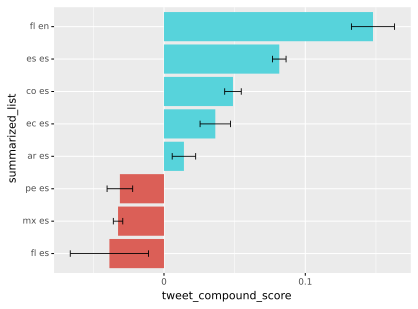

<ggplot: (350561121)>

In [70]:
(ggplot(summarized) +
 geom_bar(aes(x = "summarized_list", y = "tweet_compound_score", fill = "is_pos"), stat="identity",
          show_legend = False) + 
 geom_errorbar(aes(x = "summarized_list", ymin="ci_95_low", ymax="ci_95_high"), 
               width=.2, position=position_dodge(.9)) + 
 scale_x_discrete(limits=summarized_list) + 
 coord_flip()
)

The confidence intervals are useful for two reasons:
1. We can look for any transitions in the interval from positive to negative and vice versa. If the interval sits squarely in the positive or negative regions, we can say that the mean sentiment score is significantly positive or negative. For the  May-8-2020 to May-14-2020 data, the polarities are significant. 
2. If the intervals do not overlap with each other, we can be confident (with 95% confidence :-) in the ranking shown. For the May-8-2020 to May-14-2020 data, the "positive locations" can be ranked as shown. However, we cannot say the same for the "negative locations", e.g., `(fl, es)` is not any more negative than `(pe, es)`. 

We should also note some doubts with `(fl, en)`. Even when using the mean, its mean polarity score is extremely high compared to the others. It would be good to compare this result with other weeks in the DHCOVID corpus, but the discrepancy may point to limitations in the bilingual lexicon used or in other aspects of the approach to 
sentiment analysis taken here. 